## Check for permuted values

In [ ]:
from utils import *
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls =[0.05, 0.1, 1, 5]
n = 50; m = n
d = 500
_model_, model_params = models.null , {}
X = _model_(**model_params)(d).sample_X(n)
Y = _model_(**model_params)(d).sample_Y(m)
p_values, obs_value, permuted_values = run_fast(X,Y, num_permutations, kernel_name, ridge_ls, band_factor_ls, light = False, return_all = True)

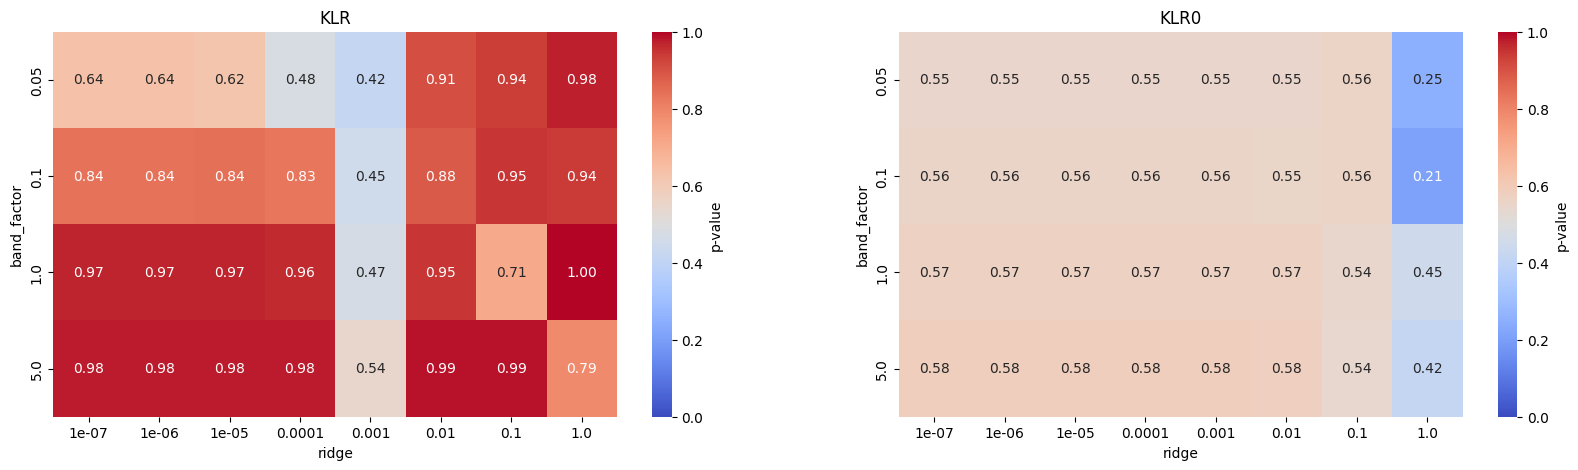

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for name, ax in zip(['KLR', 'KLR0'], axs):
    p_values = [
        [
            r, 
            BF, 
            np.mean(permuted_values[name, r, BF] >= obs_value[name, r, BF]) 
        ]
         for r in ridge_ls for BF in band_factor_ls ]
    bonferroni_corrected_p_values = np.array([[r, BF, min(0.5, p * len(ridge_ls) * len(band_factor_ls))] for r, BF, p in p_values])
    sns.heatmap(pd.DataFrame(p_values, columns= ['ridge', 'band_factor', 'p_value']).pivot(columns='ridge', index='band_factor', values='p_value'),
                    annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'p-value'}, vmin=0, vmax=1, ax=ax)
    ax.set_title(name)

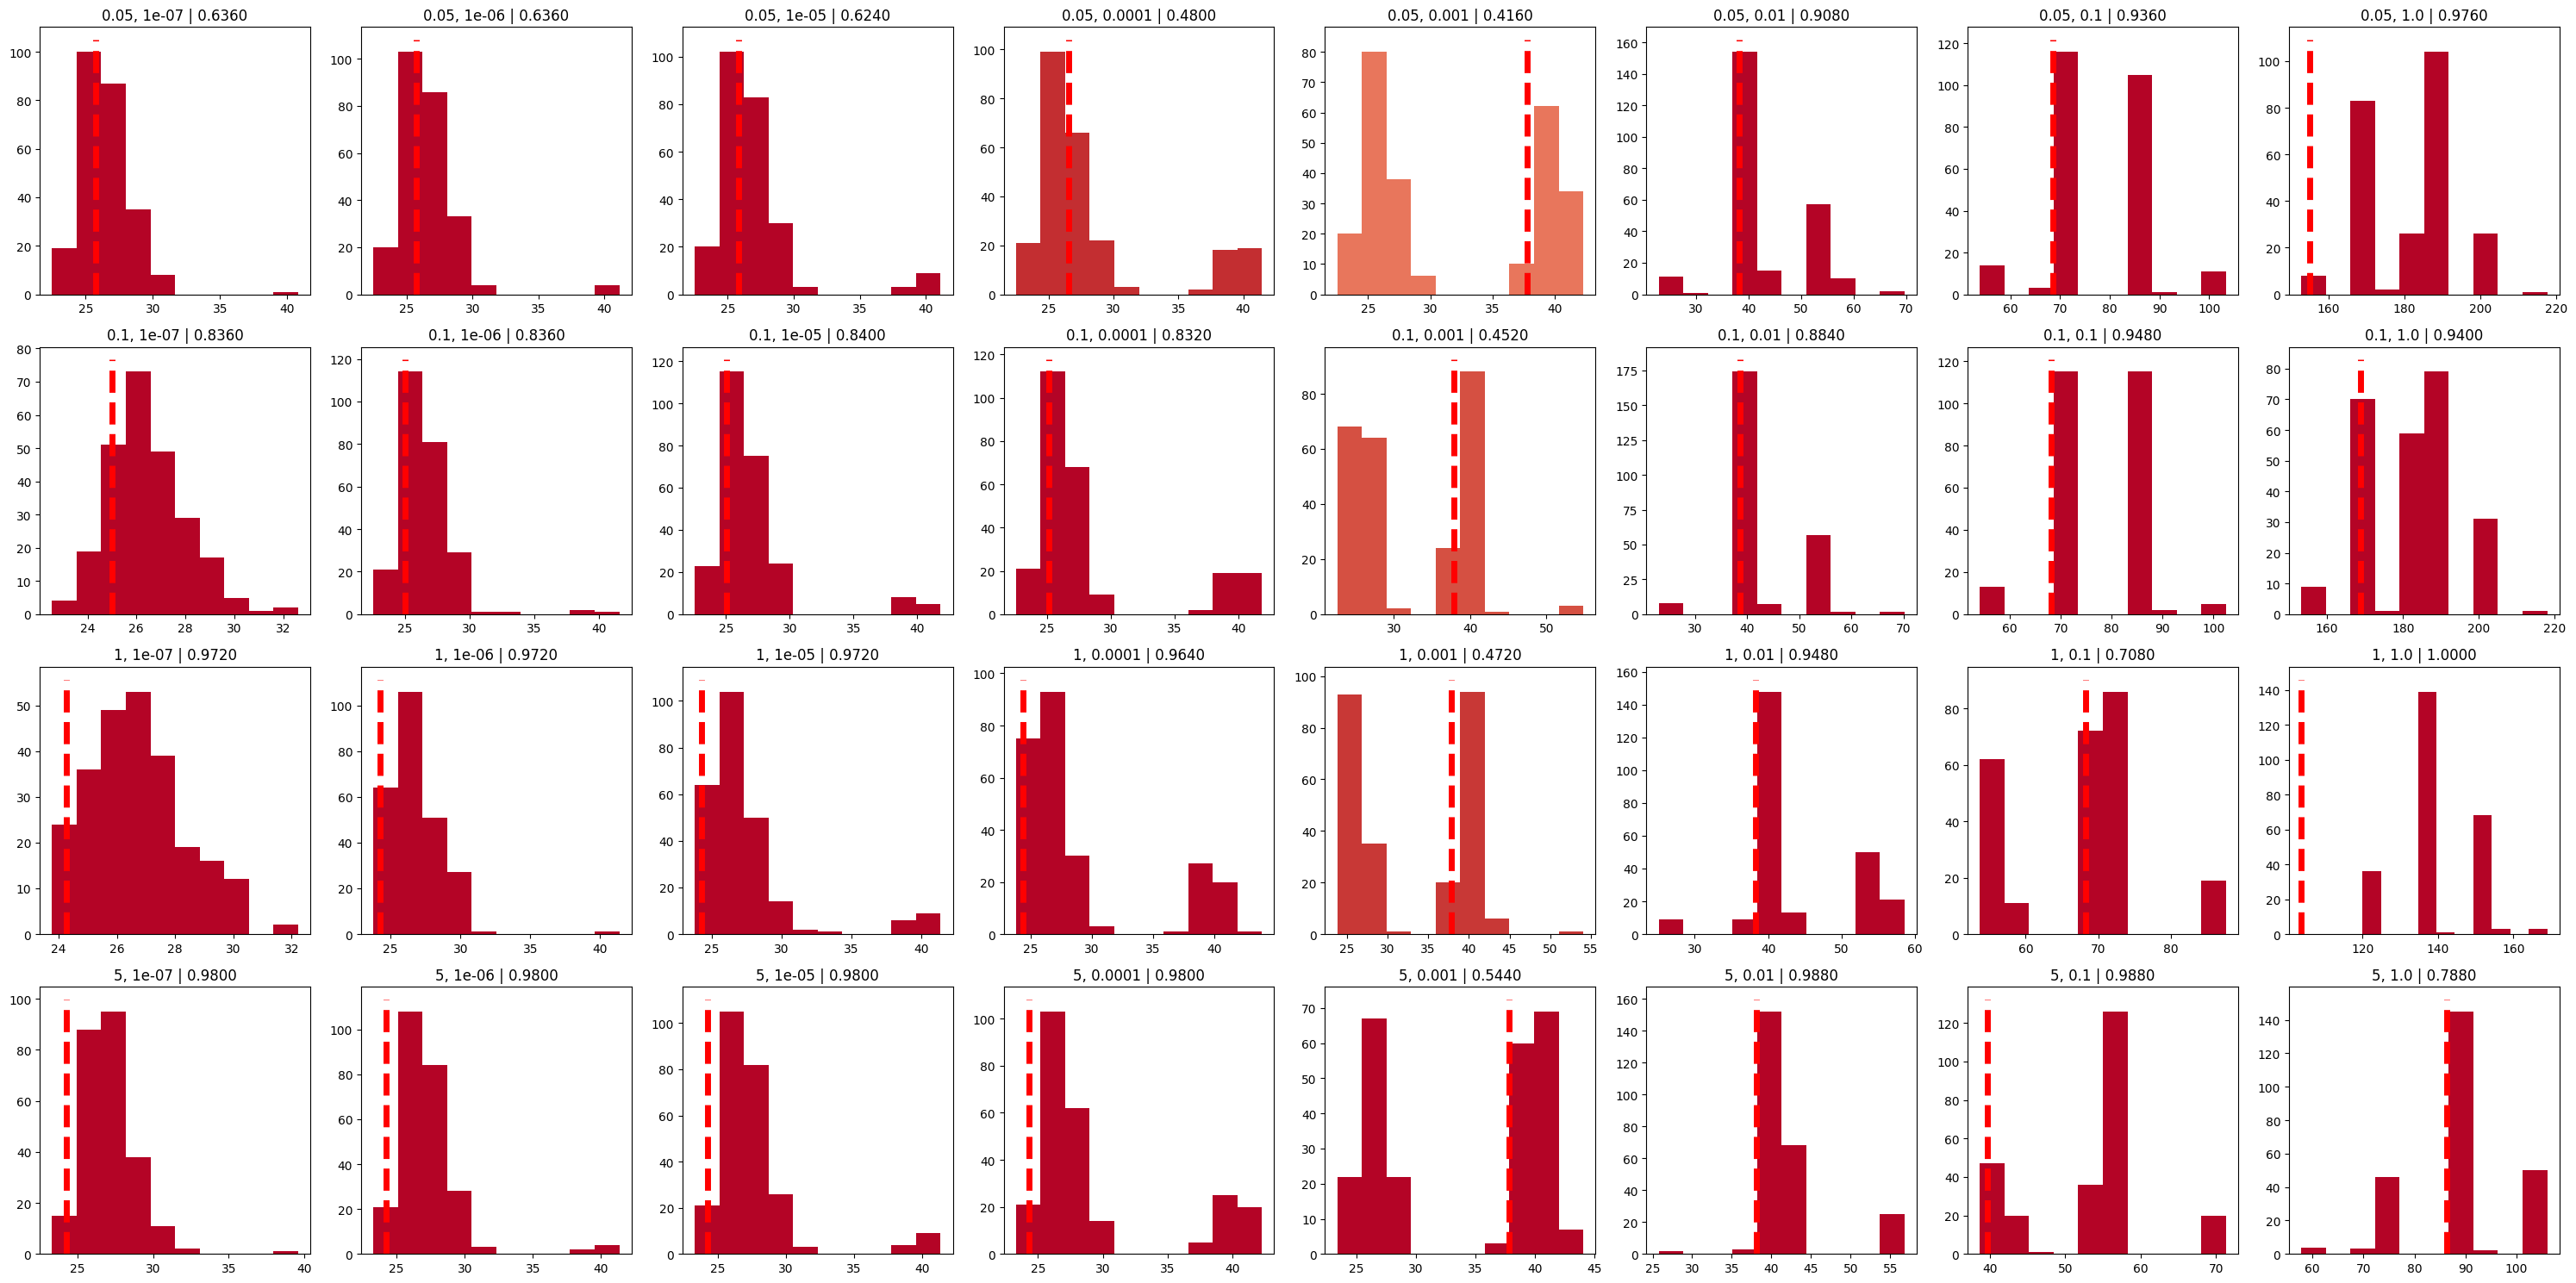

In [3]:
name = 'KLR'
fig, axs = plt.subplots(len(band_factor_ls), len(ridge_ls), figsize=(30, 15)); axs = axs.flatten()
cmap = plt.get_cmap('coolwarm')
for i, (r, BF) in enumerate([(r, BF)  for BF in band_factor_ls for r in ridge_ls]):
    try:
        pval = np.mean(permuted_values[name, r, BF] >= obs_value[name, r, BF])
        axs[i].hist(np.ravel(permuted_values[name, r, BF]), color = cmap(pval/0.5))
        axs[i].vlines(obs_value[name, r, BF], ymin=0, ymax=axs[i].get_ylim()[1], color='red', linestyle='--', lw = 5)
        axs[i].set_title(f"{BF}, {r} | {pval:.4f}")
    except:
        None
plt.tight_layout()
plt.show()

___

In [17]:
X = _model_(**model_params)(d).sample_X(n)
Y = _model_(**model_params)(d).sample_Y(m)
n = len(X); m = len(Y)
fullsample = np.concatenate([X, Y])
pairwise_dists = cdist(fullsample, fullsample, 'sqeuclidean')
centered_pairwise_dists = pairwise_dists.copy()
bandwidth = 2 * np.median(pairwise_dists)
kernel_matrix  =  np.exp( - pairwise_dists / (bandwidth)*10) 
kxx, kyy, kxy = split_kernel(kernel_matrix, n, m); kyx = kxy.T
KmatX = np.concatenate([kxx, kyx])
KmatY = np.concatenate([kxy, kyy])
mX = np.mean(KmatX, axis=1, keepdims=True)
mY = np.mean(KmatY, axis=1, keepdims=True)
SY = KmatY @ (KmatY.T)/m
SX = KmatX @ (KmatX.T)/n 
m_avg = (mX + mY)/2

reg = 1e-6
S_avg = (SX+SY)/2 + np.eye(n+m)*reg
C = np.cov(kernel_matrix.T) + np.eye(n+m)*reg


eigvals_C, eigvecs_C = np.linalg.eigh(C)
eigvals_S_avg, eigvecs_Savg = np.linalg.eigh(S_avg)


# eigvals_C, eigvecs_C = scipy.linalg.eigh(C)
# eigvals_S_avg, eigvecs_Savg = scipy.linalg.eigh(S_avg)


# eigvals_C, eigvecs_C,_=  np.linalg.svd(C)




In [6]:
_perm = np.random.permutation(n + m)
_kernel_matrix =  kernel_matrix[np.ix_(_perm,_perm)]
_kxx, _kyy, _kxy = split_kernel(_kernel_matrix, n, m); _kyx = _kxy.T
_KmatX = np.concatenate([_kxx, _kyx])
_KmatY = np.concatenate([_kxy, _kyy])
_mX = np.mean(_KmatX, axis=1, keepdims=True)
_mY = np.mean(_KmatY, axis=1, keepdims=True)
_SX = _KmatX @ (_KmatX.T)/n
_SY = _KmatY @ (_KmatY.T)/m
_S_avg = (_SX + _SY)/2
_m_avg = (_mX + _mY)/2
_C = np.cov(_kernel_matrix.T)
_eigvals_C, _eigvecs_C = np.linalg.eigh(_C)
_inv_perm = np.argsort(_perm)
_eigvals_S_avg, _eigvecs_Savg = np.linalg.eigh(_S_avg + np.eye(n+m)*1e-15)


In [41]:
A = eigvecs_C @ np.diag([1/c if c > 1e-15 else 0 for c in eigvals_C]) @ eigvecs_C.T @ C
print(np.allclose(A, np.eye(n+m), atol=1e-8))  # Should be True or close to it
sns.heatmap(C[np.ix_(_perm, _perm)] - _C)
print(np.allclose(C[np.ix_(_perm, _perm)], _C))
# sns.heatmap(_C[np.ix_(_inv_perm, _inv_perm)] - C)
sns.heatmap( _eigvecs_C- eigvecs_C[_perm, :]  )
print(np.allclose(_eigvecs_C, eigvecs_C[_perm, :]))

False


# Figuring out projection and symmetrisation

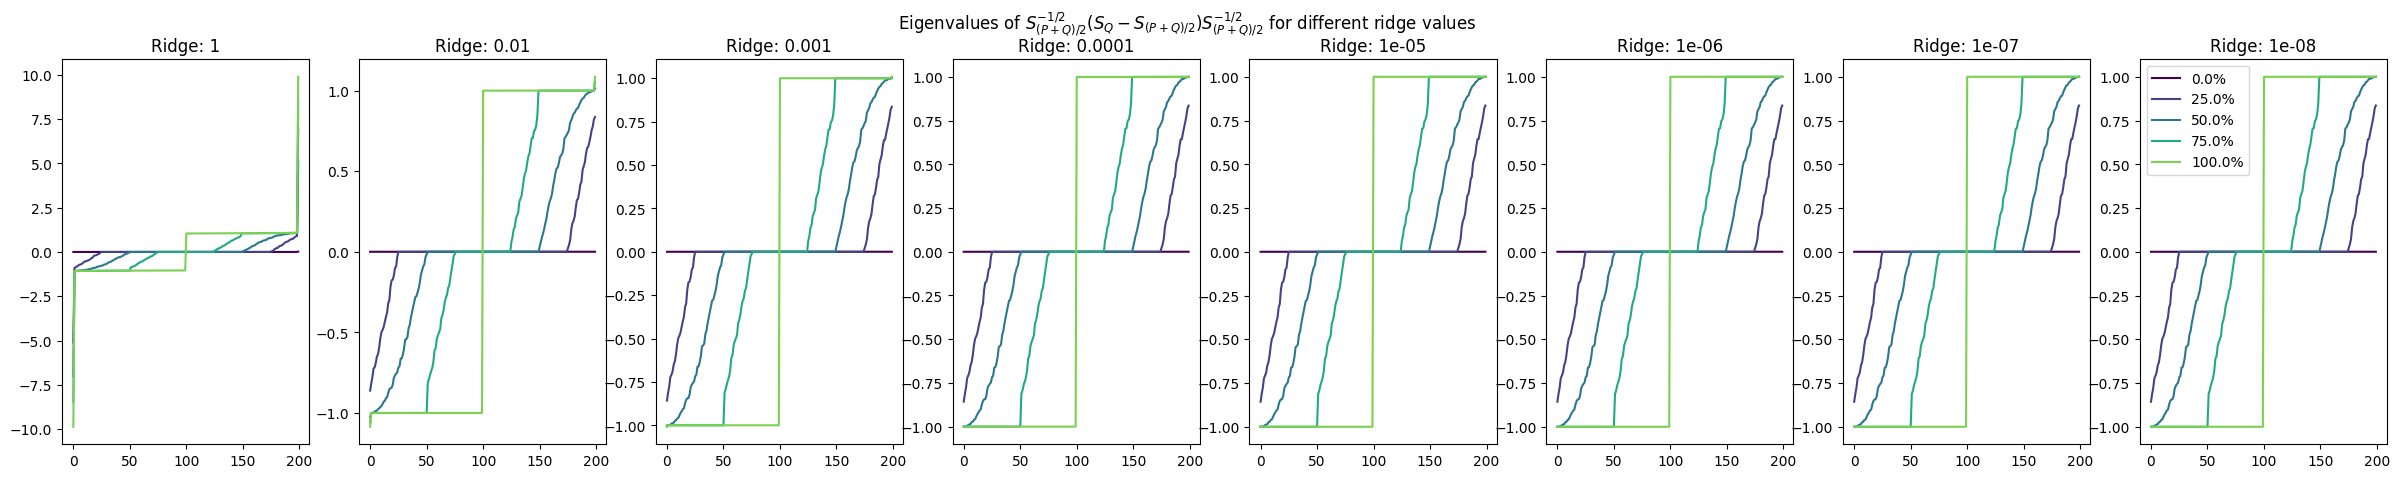

In [4]:
from utils import *
n, m = 100, 100
_model_, model_params = models.null, {}
X = _model_(**model_params)(d).sample_X(n)
Y = _model_(**model_params)(d).sample_X(m)
fullsample = np.concatenate([X, Y])
pairwise_dists = cdist(fullsample, fullsample, 'euclidean')
bandwidth = 2 * np.median(pairwise_dists[pairwise_dists > 0])
kernel_matrix  =  np.exp( - cdist(fullsample, fullsample, kernel_name) / bandwidth)
kxx, kyy, kxy = split_kernel(kernel_matrix, n, m); kyx = kxy.T
KmatX = np.concatenate([kxx, kyx])
KmatY = np.concatenate([kxy, kyy]) 
mX = np.mean(KmatX, axis=1, keepdims=True)
mY = np.mean(KmatY, axis=1, keepdims=True)
SY = KmatY @ (KmatY.T)/m
SX = KmatX @ (KmatX.T)/n 
m_avg = (mX + mY)/2
max_cond_number = 1e9
S_avg = regularize_to_condition_number( (SX+SY)/2, 1e9)
C  = regularize_to_condition_number( np.cov(kernel_matrix.T),1e9)
eigvals_C, eigvecs_C = np.linalg.eigh(C)
eigvals_S_avg, eigvecs_Savg = np.linalg.eigh(S_avg)

rs = [1,1e-2, 1e-3,1e-4,1e-5, 1e-6, 1e-7,1e-8]
fig, axs = plt.subplots(figsize=(30, 5), ncols=len(rs))
fig.suptitle('Eigenvalues of $S_{(P+Q)/2}^{-1/2}(S_Q-S_{(P+Q)/2})S_{(P+Q)/2}^{-1/2}$ for different ridge values')
cmap = colormaps['viridis']
for ax, r in zip(axs, rs):
    ax.set_title(f'Ridge: {r}')
    nks = 5
    for i, factor in enumerate(np.linspace(0,1,nks)):
        K = int(2*n*factor)
    # for i, K in enumerate(np.arange(SX.shape[0] // 2, SX.shape[0] + 1, 5)):
        inv_sqrtm_Savg = inv_sqrtm_ED((eigvals_S_avg, eigvecs_Savg), r)
        projection_matrix = eigvecs_Savg[:, -K-1:] @ eigvecs_Savg[:, -K-1:].T
        # innerHSmat_eigvals = np.linalg.eigvalsh(projection_matrix@inv_sqrtm_SX @ ( projection_matrix @SY @  projection_matrix.T - SX) @ inv_sqrtm_SX @  projection_matrix.T)
        innerHSmat_eigvals = np.linalg.eigvalsh(inv_sqrtm_Savg @  projection_matrix @(SY - S_avg) @  projection_matrix.T @ inv_sqrtm_Savg)
        ax.plot(innerHSmat_eigvals, label=f'{factor*100}%', color=cmap(i /  nks))
    
    # projection_matrix = np.eye(n+n)#eigvecs_SX[:,:] @ eigvecs_SX[:,:].T
    # innerHSmat_eigvals = np.linalg.eigvalsh(projection_matrix@inv_sqrtm_Savg @ ( projection_matrix @SY @  projection_matrix.T - SX) @ inv_sqrtm_SX @  projection_matrix.T)
    # ax.plot(innerHSmat_eigvals, label=f'NONE', color='red', linestyle='--')
    # innerHSmat_eigvals = np.linalg.eigvalsh(inv_sqrtm_Savg @ (SY - S_avg) @ inv_sqrtm_Savg)
    # ax.plot(innerHSmat_eigvals, label=f'NONE', color='red', lw=5, alpha = .3)
plt.legend()
plt.show()

# Crossvalidation for bandwith/regularisation selection

In [ ]:
from utils import *
NUM_CORES = 8
n, d = 50, 250
N_iters = 8
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.03, 0.1, 1, 3, 10, 30]
light = True

_model_, model_params = (models.GaussianSpikedCovariance , {'spike_value' : 4, 'num_spikes' : 8})

results = []
for band_factor, ridge in tqdm([(band_factor, ridge) for band_factor in band_factor_ls for ridge in ridge_ls]):
    args = (n, d, _model_, model_params, num_permutations, N_iters, NUM_CORES, kernel_name, [ridge], [band_factor], light )
    out = run_fast_parallel(*args)
    test_names = out[0].keys()
    for test_name in test_names:
        decisions = [_[test_name] for _ in out]
        results += [[band_factor, ridge, test_name, np.mean(decisions), np.std(decisions)]]

data = pd.DataFrame( results, columns = ['band_factor','ridge', 'test_name', 'rejection_rate', 'std'])
fig, axs = plt.subplots(1, len(test_names), figsize=(15, 5), sharey=True)
fig.suptitle(f'{_model_.__name__}', fontsize=16)
for ax, name in zip(axs, test_names):
    subset = data[data.test_name == name].pivot(index='ridge', columns='band_factor', values='rejection_rate')
    sns.heatmap(subset, ax=ax, annot=True, fmt=".1f", cmap="RdBu", cbar_kws={'label': 'Rejection Rate'}, vmin=0, vmax=1, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('band_factor')
    ax.set_ylabel('ridge')
    ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <generator object tqdm.__iter__ at 0x139366040><generator object tqdm.__iter__ at 0x139366040><generator object tqdm.__iter__ at 0x139366040><generator object tqdm.__iter__ at 0x139366040>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/leonardosantoro/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1196, in __iter__
  File "/Users/leonardosantoro/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1196, in __iter__
  File "/Users/leonardosantoro/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1196, in __iter__
  File "/Users/leonardosantoro/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1196, in __iter__
        Exception ignored in:         self.close()self.close()Exception ignored in: Exception 

KeyboardInterrupt: 

# Adaptive run

In [ ]:
from utils import *
NUM_CORES = 8
N_iters = 8
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
# ridge_ls = np.logspace(-5, 2, 8)
band_factor_ls = [0.05, 0.1, 1, 5,10]

n, d  = 120, 500
# _model_, model_params = models.null , {}
# _model_, model_params = (models.GaussianMixture, {'mu' : 4, 'P' : 1})
# _model_, model_params = models.ConcentricSpheres, {'shift': 0.01, 'noise' : 0.01}

_model_, model_params = models.GaussianSpikedCovariance , {'spike_value' : 4, 'num_spikes' : 5}

# n, d  = 100, 500
# _model_, model_params = models.DecreasingCorrelationGaussian , {'alpha' : 0.5, 'eps' : 0.25}
# _model_, model_params = models.EquiCorrelationGaussian , {'alpha' : 0.5, 'eps' : 0.1}


n, d  = 50,3
_model_, model_params = models.VMF, {'kappa': 10}
# _model_, model_params = models.ConcentricSpheres, {'shift': 0.01, 'noise' : 0.01}

n, d  = 50, 500
_model_, model_params = models.ConcentricSpheres, {'shift': 0.02, 'noise' : 0.0}

# _model_, model_params = models.DiracGaussianMixture , {'eps' : 0.1}

# n, d  = 75, 3
# _model_,model_params = (models.LaplaceSparseMeanShift , {'mu' : 2, 'P' : 1})
# _model_,model_params = (models.GaussianSparseMeanShift , {'mu' : .05, 'P' : d})
_model_,model_params = models.UniformThinHypercube , {'epsilon' : 0.01, 'P' : 500}


# -------------------- run ------------------------------------------------------------------------------------------------------------------------------------------------
out = run_fast_parallel(n, d, _model_, model_params, num_permutations, N_iters, NUM_CORES, kernel_name, ridge_ls, band_factor_ls, True, True)



   sample_size  dimension    test_name  rejection_rate              CI
0           50        500          KLR           1.000    (0.676, 1.0)
1           50        500        *KLR*           1.000    (0.676, 1.0)
2           50        500           CM           1.000    (0.676, 1.0)
3           50        500         KLR0           0.875  (0.529, 0.978)
4           50        500      logdet2           0.875  (0.529, 0.978)
5           50        500       AggMMD           0.750  (0.409, 0.929)
6           50        500  SpecReg-MMD           0.625  (0.306, 0.863)


In [ ]:
from utils import *

NUM_CORES = 8
N_iters = 8
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.05, 0.1, 1, 5,10]

n, d  = 75,1000
_model_, model_params = (models.GaussianMixture, {'mu' : 4, 'P' : 1})
# _model_,model_params = (models.LaplaceSparseMeanShift , {'mu' : 0.5, 'P' : 10})

# n, d  = 100,1000
# _model_, model_params = (models.ConcentricSpheres , {'shift' : 0.01, 'noise' : 0.02})


# -------------------- run ------------------------------------------------------------------------------------------------------------------------------------------------
out = run_fast_parallel(n, d, _model_, model_params, num_permutations, N_iters, NUM_CORES, kernel_name, ridge_ls, band_factor_ls, True, True)


   sample_size  dimension    test_name  rejection_rate              CI
0           75       1000         KLR0           0.875  (0.529, 0.978)
1           75       1000        *KLR*           0.875  (0.529, 0.978)
2           75       1000      logdet2           0.750  (0.409, 0.929)
3           75       1000          KLR           0.375  (0.137, 0.694)
4           75       1000       AggMMD           0.125  (0.022, 0.471)
5           75       1000           CM           0.000    (0.0, 0.324)
6           75       1000  SpecReg-MMD           0.000    (0.0, 0.324)


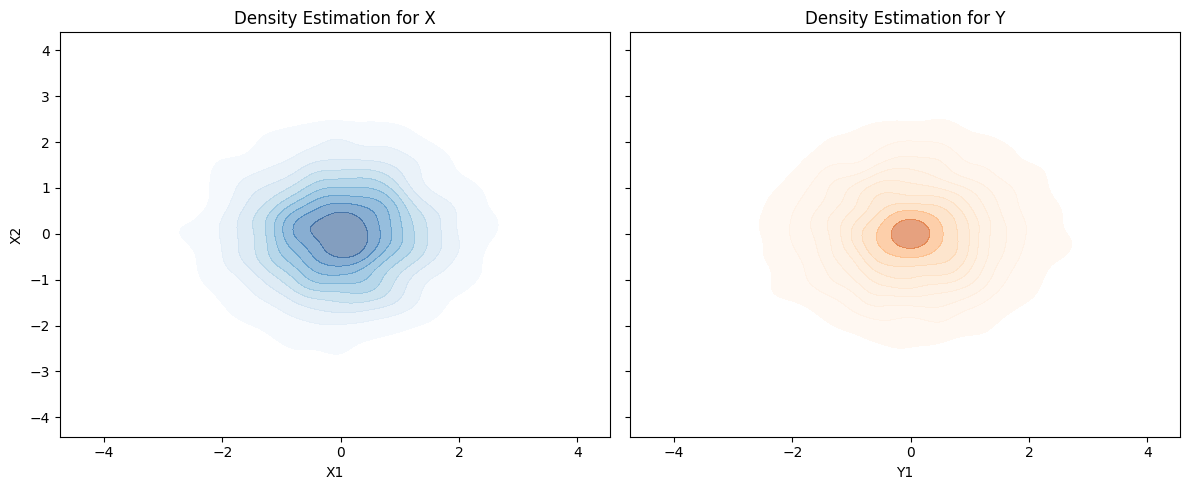

In [50]:
n = 5000
# _model_, model_params = models.LaplaceGaussian, {}
_model_, model_params = models.DiracGaussianMixture , {'eps' : 0.1}

X = _model_(**model_params)(d).sample_X(n)
Y = _model_(**model_params)(d).sample_Y(n)
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex = True)

sns.kdeplot(x=X[:, 0], y=X[:, 1], ax=axs[0], cmap="Blues", fill=True, alpha=0.5)
axs[0].set_title("Density Estimation for X")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")

sns.kdeplot(x=Y[:, 0], y=Y[:, 1], ax=axs[1], cmap="Oranges", fill=True, alpha=0.5)
axs[1].set_title("Density Estimation for Y")
axs[1].set_xlabel("Y1")
axs[1].set_ylabel("Y2")

plt.tight_layout()
plt.show()


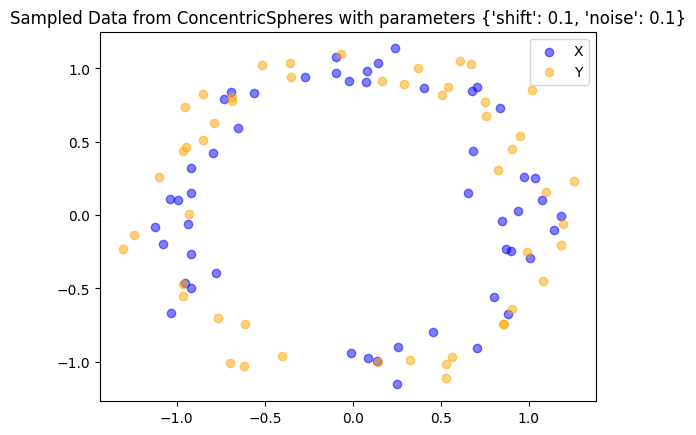

In [ ]:
n = 50
X = _model_(**model_params)(d).sample_X(n)
Y = _model_(**model_params)(d).sample_Y(n)
plt.scatter(X[:, 0], X[:, 1], label='X', alpha=0.5, color='blue')
plt.scatter(Y[:, 0], Y[:, 1], label='Y', alpha=0.5, color='orange')
plt.title(f"Sampled Data from {_model_.__name__} with parameters {model_params}")
plt.legend()
plt.show()

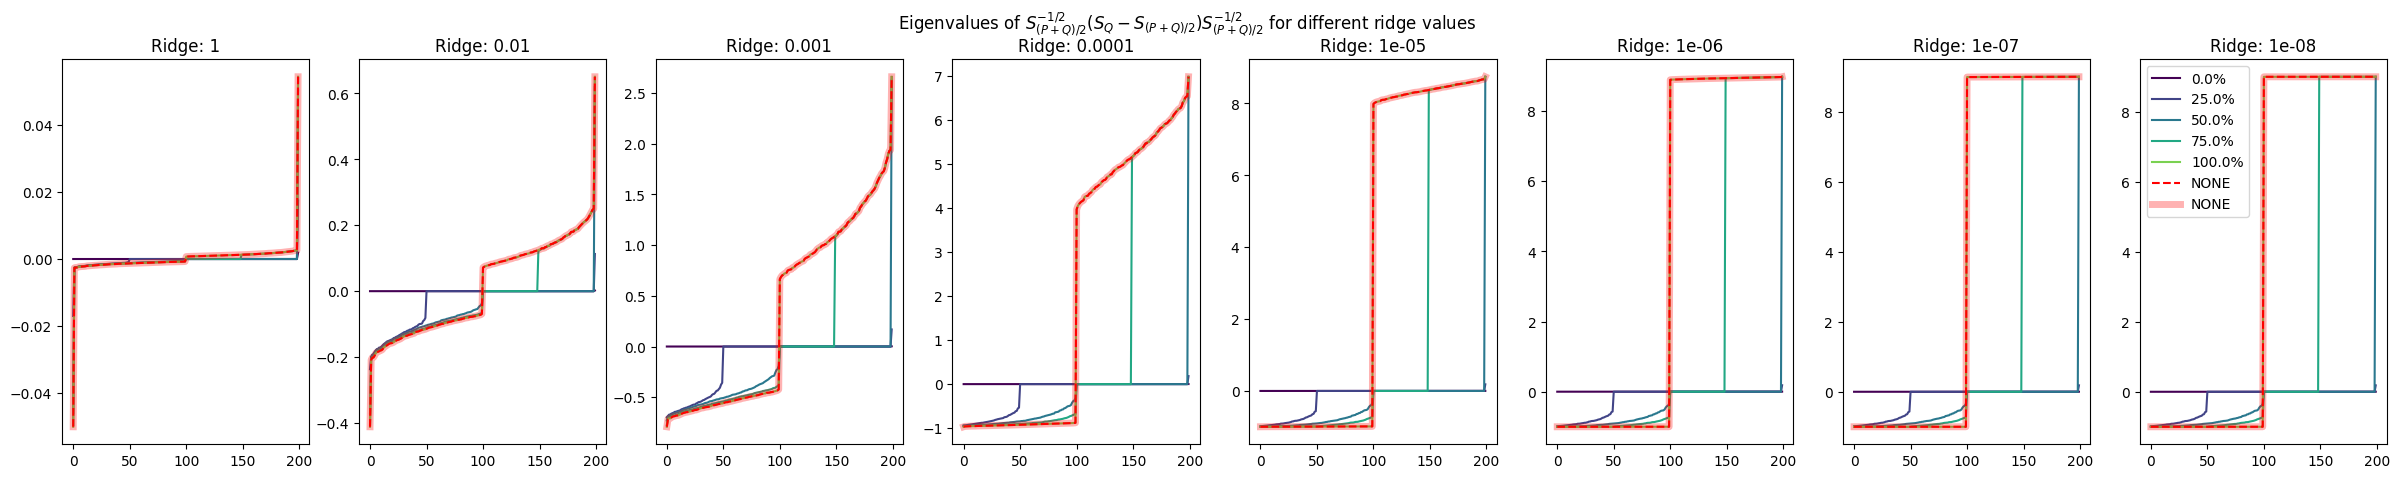

In [ ]:
# # as Hagrass
# ridge_ls = 10 ** np.arange(-6, 1.01, 0.75)
# band_factor_ls = 10 ** np.arange(-2, 2 + 0.01, 0.5)
# band_factor_ls = [0.03, 0.1, 1, 3, 10, 30]
